# Unet - Constructed from the main CNN encoder and Decoder

This notebook shows how to use the CNN encoder and decoder network, glueing them 
together such that an Unet architecture emerges

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../Shared_Resources/Shared_Scripts')
sys.path.append('./utils')


from utils_unet_from_encoder_decoder import UNet
from utils_dataset_handling import get_data_loader
from utils_segmentation_training import *
from utils_save_and_load_model import *

## Download the data set

In [3]:
data_save_dir = '../../Shared_Resources/Shared_Data/'

### Preprocessing and data augmentation

In [4]:
#--- downsampling---
image_size = 40

In [5]:
#--- data augmentation ----
common_transform = T.Compose([
        ToDevice(get_device()),
        T.Resize((image_size,image_size), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ])

post_transform = T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ])

In [6]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=common_transform,
    post_transform=post_transform,
    post_target_transform=T.Compose([ T.Lambda(tensor_trimap)]),
)

### Data Loader

In [7]:
pets_train_loader, pets_test_loader = get_data_loader(data_save_dir, transform_dict, 
                                            download=False, batch_size_train=10, batch_size_test=10)



In [8]:
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([10, 3, 40, 40]), torch.Size([10, 1, 40, 40]))

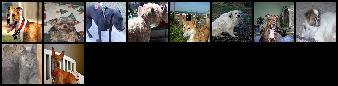

In [9]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

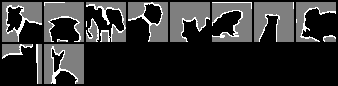

In [10]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

### Training functions

In [11]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#

def plot_losses(loss_dict):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_dict['loss_train'], label='Training Loss')
    plt.plot(loss_dict['loss_test'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses Over Epochs')
    plt.legend()
    plt.show()

def train_loop(model, train_loader, test_loader, test_data, epochs, optimizer, scheduler, 
               save_path,print_every=2,show_plots=False):
    
    losses = {'loss_train': [],'loss_test': []}#here we store the losses
    
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        
        running_samples, average_loss = train_model(model, train_loader, optimizer, mode='train')
        losses['loss_train'].append(average_loss)
        print("Trained {} samples, Loss: {:.4f}".format(running_samples,average_loss,))
        
        
        running_samples, average_loss = train_model(model, test_loader, mode='eval',max_batches=10)
        losses['loss_test'].append(average_loss)
        print("Tested {} samples, Loss: {:.4f}".format(running_samples,average_loss,))
        
        if i%print_every==0 or (epoch == epoch_j-1):   
            with torch.inference_mode():
                # Display the plt in the final training epoch.
                print_test_dataset_masks(model, test_inputs, test_targets,
                                         epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1) or show_plots)
            plot_losses(losses)

        if scheduler is not None:
            scheduler.step()

### Initialize Unet model

In [12]:
dimension_specification =   {0: {'width_encoder': 15, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                 'width_decoder': 20, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 15},
                            1: {'width_encoder': 30, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                'width_decoder': 30, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 30},
                             2: {'width_encoder': 30, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                'width_decoder': 30, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 30}
                            }

In [13]:
config = {'in_ch': 3,
         'out_ch': 3,
         'n_decoders': 1,
          'output_groupname_to_n_channels': {'object_mask': 3},
          'output_groupname_to_name_to_idx': {'object_mask': {'background': 1,'border': 2,'object': 0}},
          'dimension_specification': dimension_specification,
          'efficiency_optimized': True,
            }

In [14]:
unet = UNet(**config)

In [15]:
print_model_parameters(unet)

The Model has 0.14M parameters


### Train Unet

In [16]:
n_epochs=30
lr = 1e-3

In [17]:
# Optimizer and Learning Rate Scheduler.
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

Epoch: 00, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6329
Tested 110 samples, Loss: 0.5202
Epoch: 00, Accuracy[Pixel: 0.8217, IoU: 0.5773, Custom IoU: 0.6118]


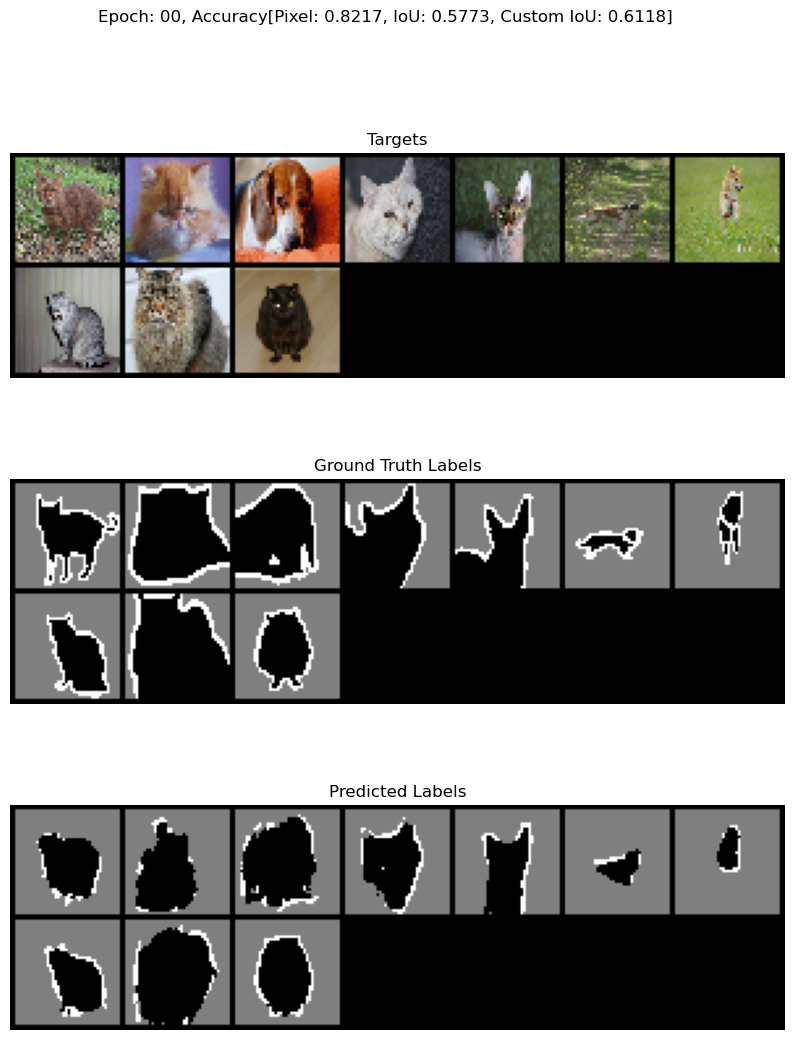

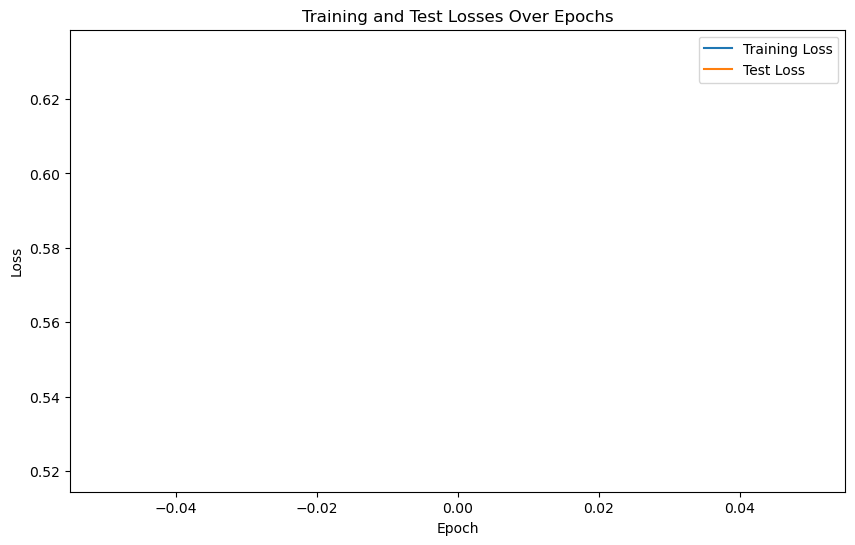

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5281
Tested 110 samples, Loss: 0.4791
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4873
Tested 110 samples, Loss: 0.4687
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4676
Tested 110 samples, Loss: 0.4472
Epoch: 03, Accuracy[Pixel: 0.8798, IoU: 0.6937, Custom IoU: 0.6972]


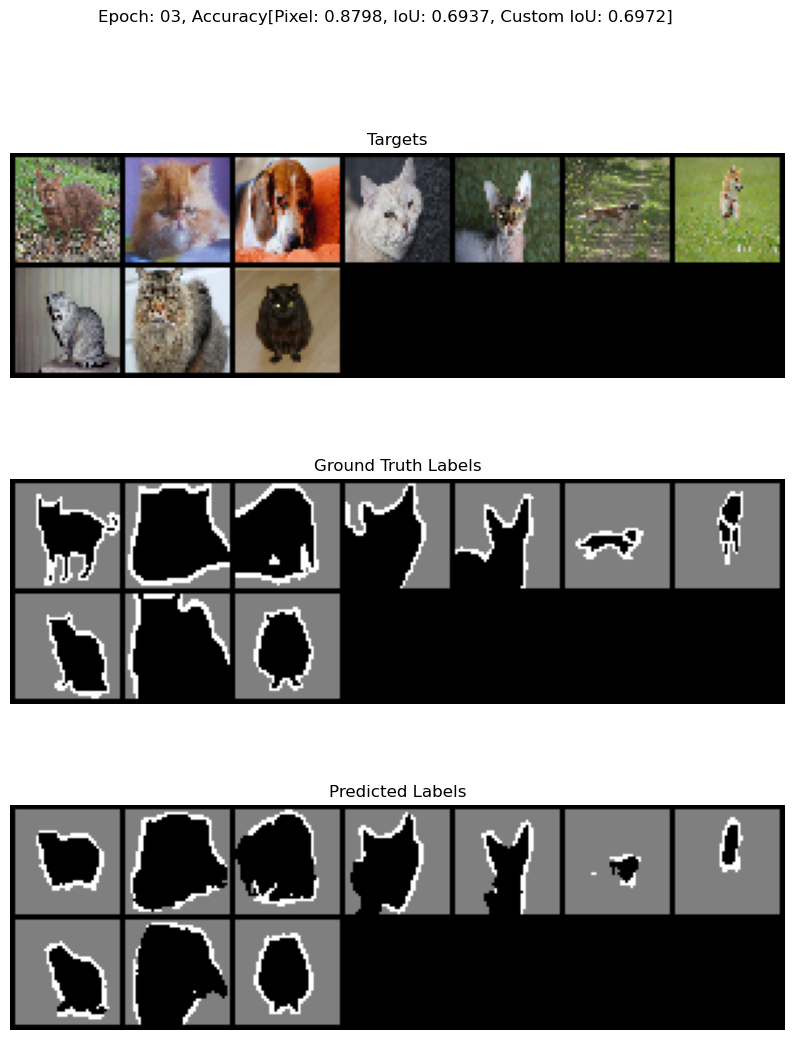

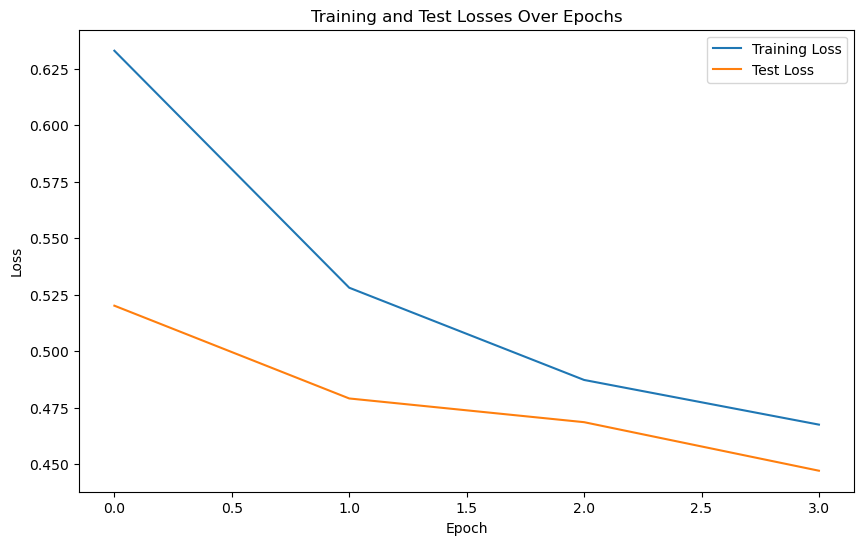

Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4467
Tested 110 samples, Loss: 0.4477
Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4338
Tested 110 samples, Loss: 0.3997
Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4222
Tested 110 samples, Loss: 0.4591
Epoch: 06, Accuracy[Pixel: 0.8882, IoU: 0.7174, Custom IoU: 0.7087]


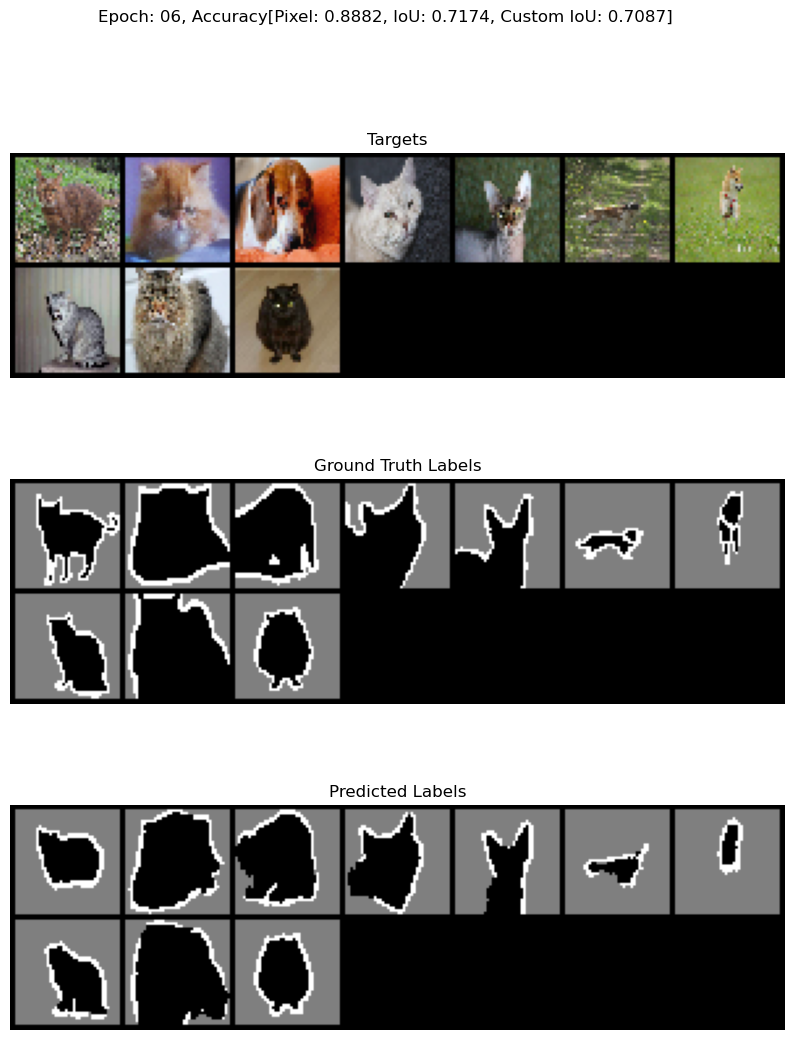

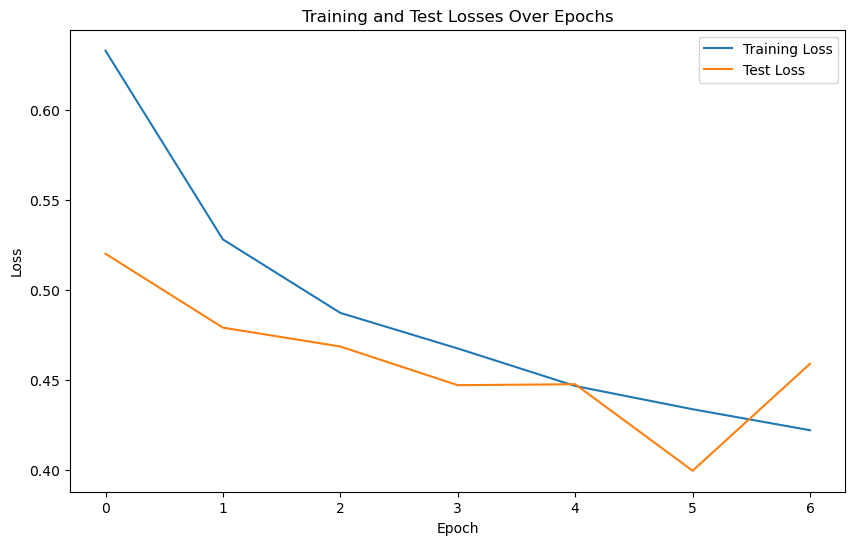

Epoch: 07, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3974
Tested 110 samples, Loss: 0.4095
Epoch: 08, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3923
Tested 110 samples, Loss: 0.3965
Epoch: 09, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3839
Tested 110 samples, Loss: 0.4017
Epoch: 09, Accuracy[Pixel: 0.8928, IoU: 0.7405, Custom IoU: 0.7089]


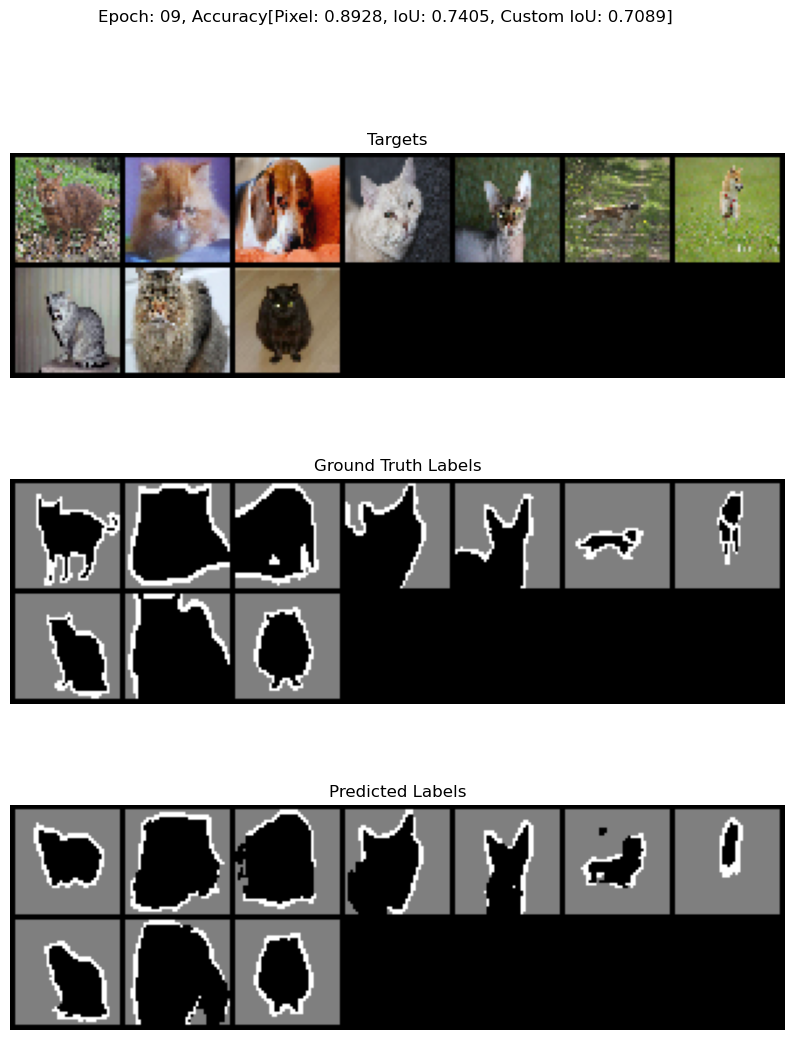

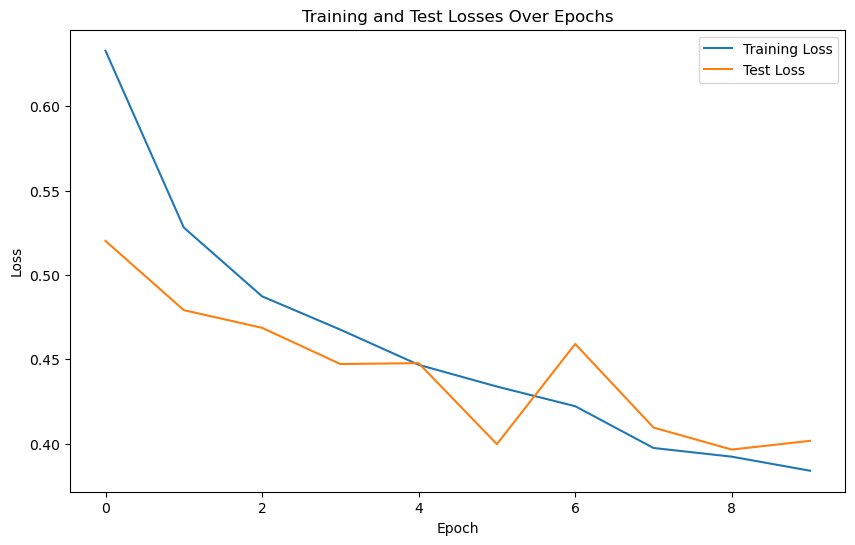

Epoch: 10, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3760
Tested 110 samples, Loss: 0.3800
Epoch: 11, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3722
Tested 110 samples, Loss: 0.4232
Epoch: 12, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3667
Tested 110 samples, Loss: 0.3695
Epoch: 12, Accuracy[Pixel: 0.9013, IoU: 0.7510, Custom IoU: 0.7442]


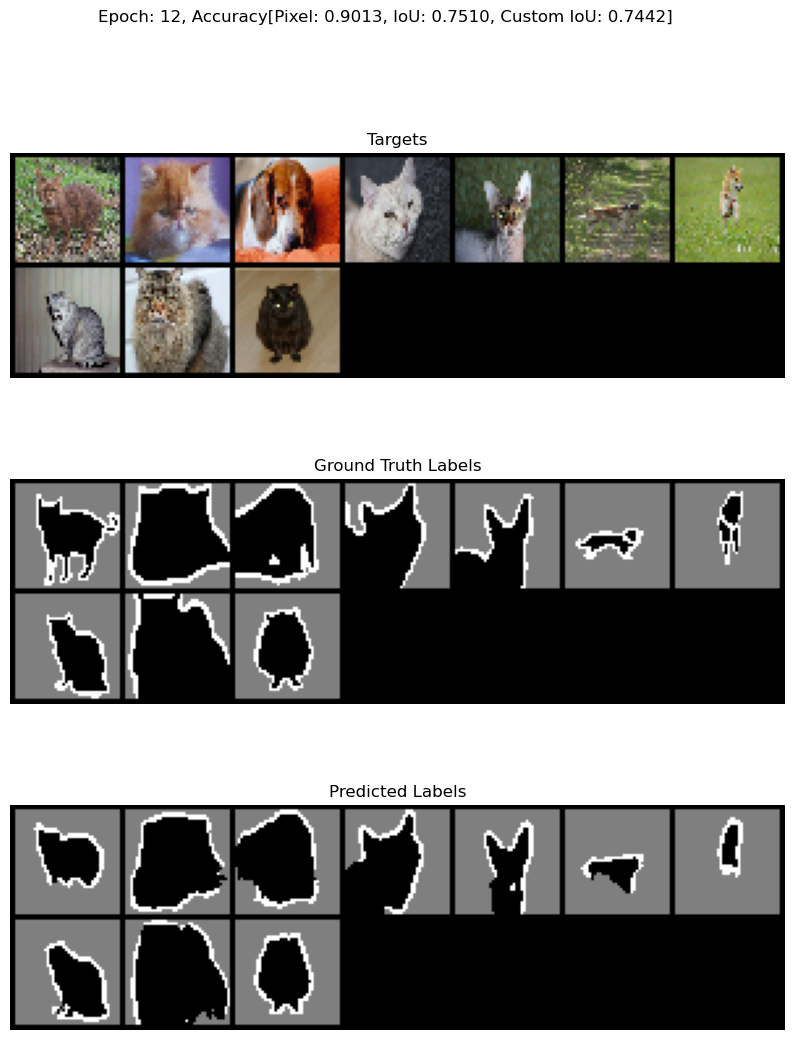

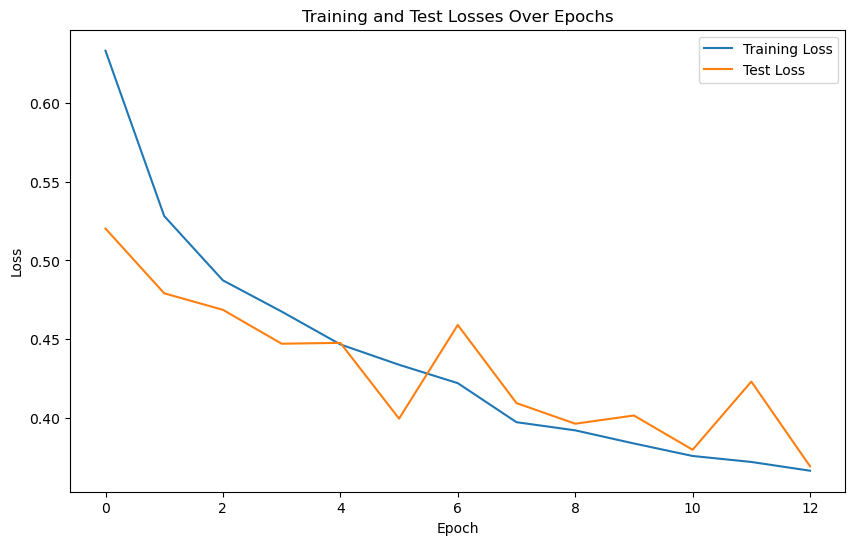

Epoch: 13, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3563
Tested 110 samples, Loss: 0.3876
Epoch: 14, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3415
Tested 110 samples, Loss: 0.3715
Epoch: 15, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3362
Tested 110 samples, Loss: 0.3851
Epoch: 15, Accuracy[Pixel: 0.8929, IoU: 0.7481, Custom IoU: 0.7410]


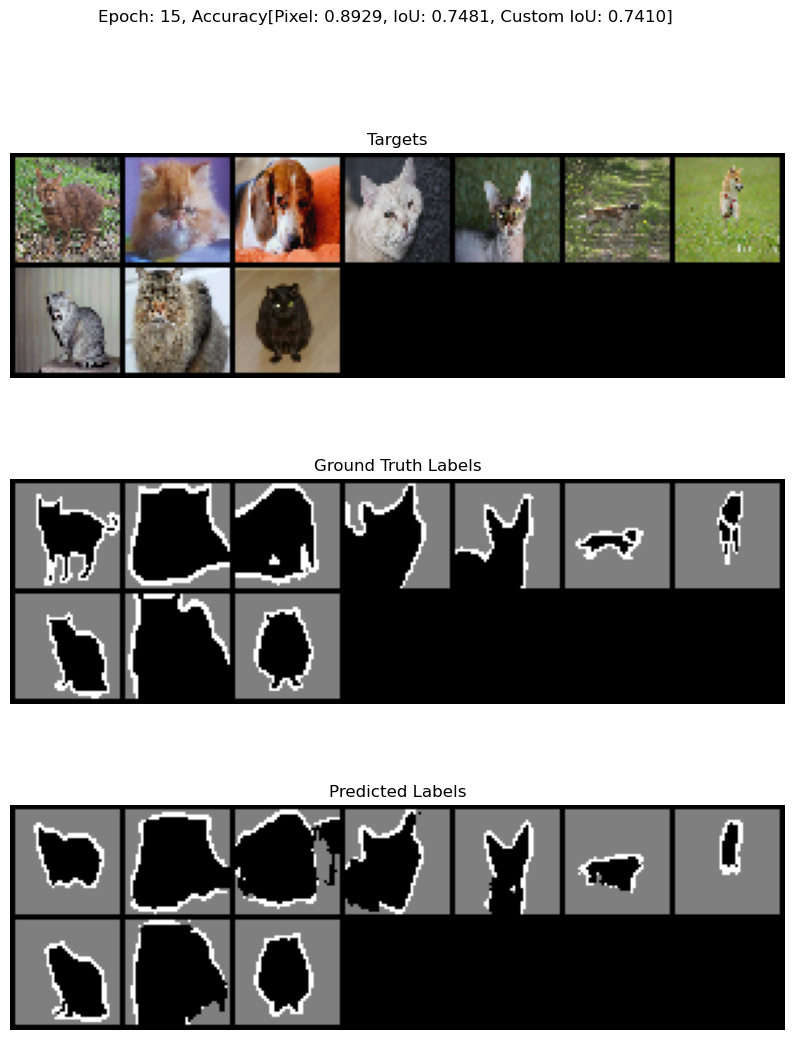

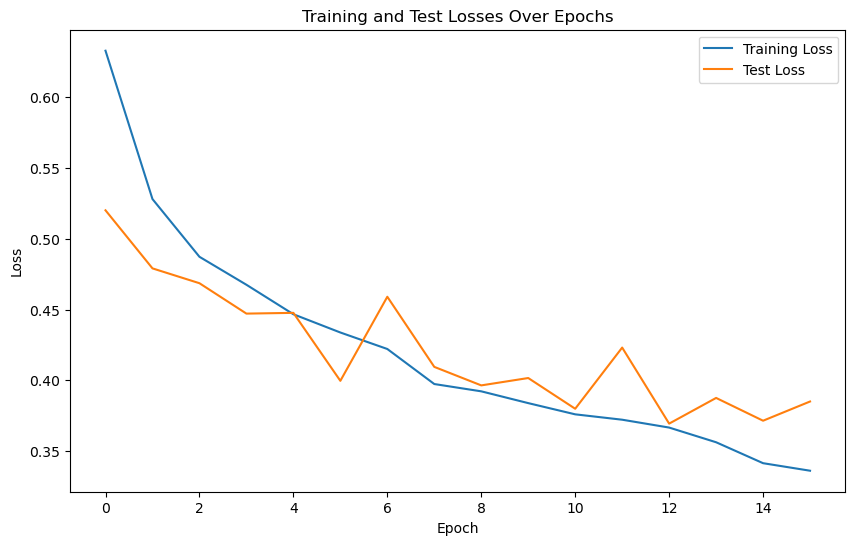

Epoch: 16, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3298
Tested 110 samples, Loss: 0.4035
Epoch: 17, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3285
Tested 110 samples, Loss: 0.3963
Epoch: 18, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3249
Tested 110 samples, Loss: 0.4224
Epoch: 18, Accuracy[Pixel: 0.9068, IoU: 0.7797, Custom IoU: 0.7571]


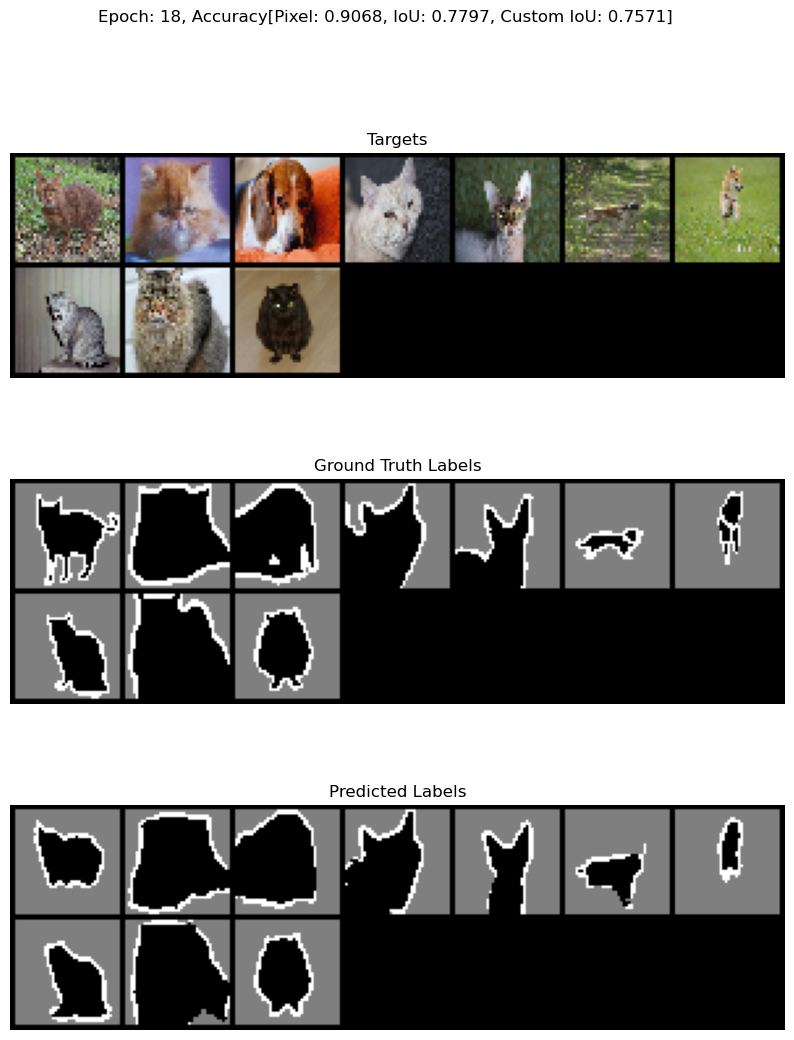

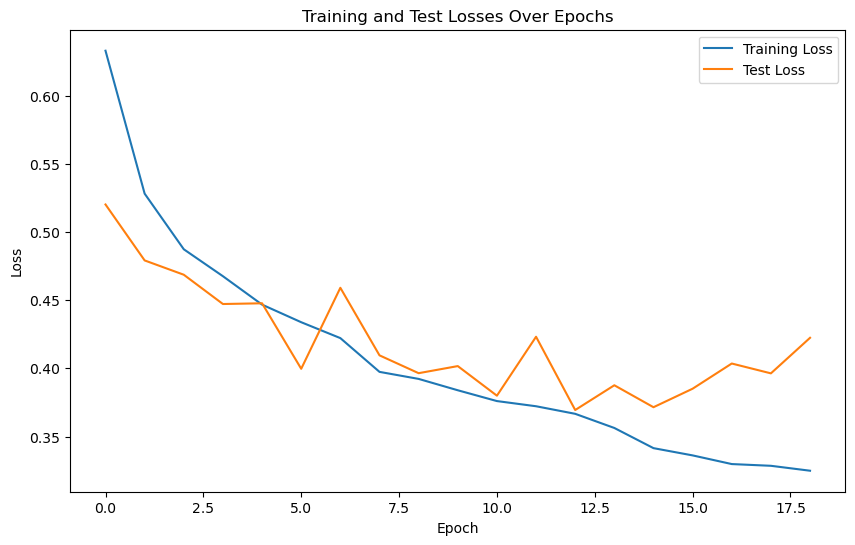

Epoch: 19, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3244
Tested 110 samples, Loss: 0.3810
Epoch: 20, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3178
Tested 110 samples, Loss: 0.3858
Epoch: 21, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.3068
Tested 110 samples, Loss: 0.3553
Epoch: 21, Accuracy[Pixel: 0.9051, IoU: 0.7668, Custom IoU: 0.7627]


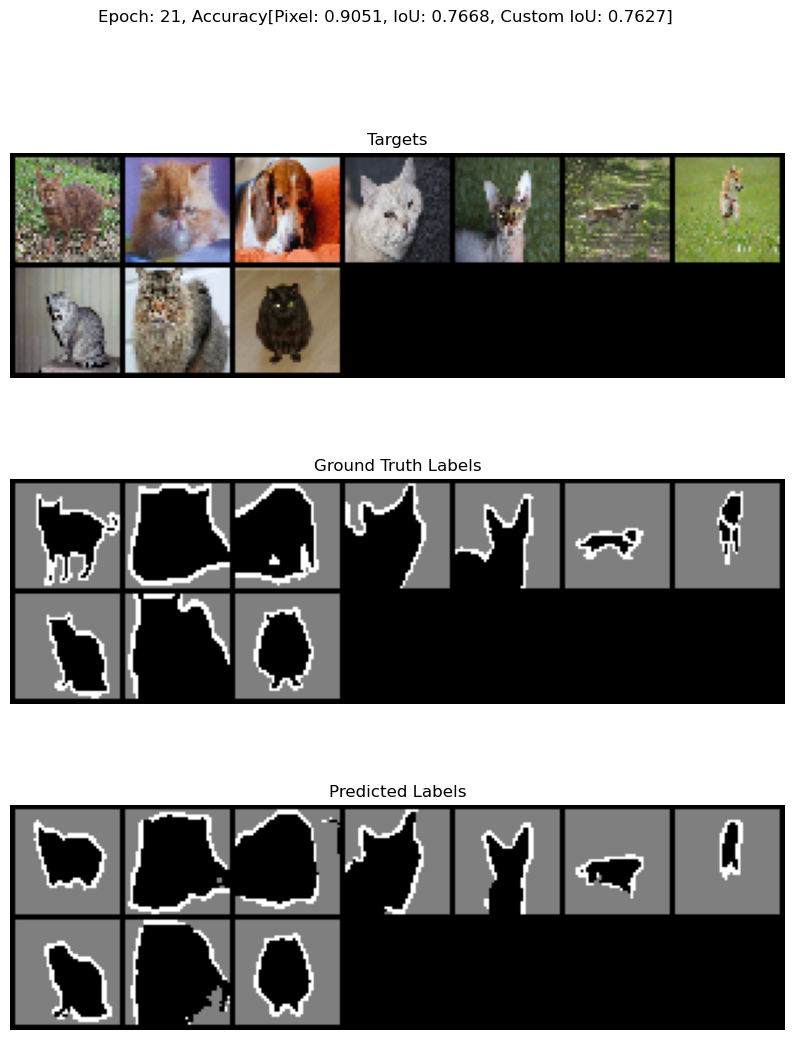

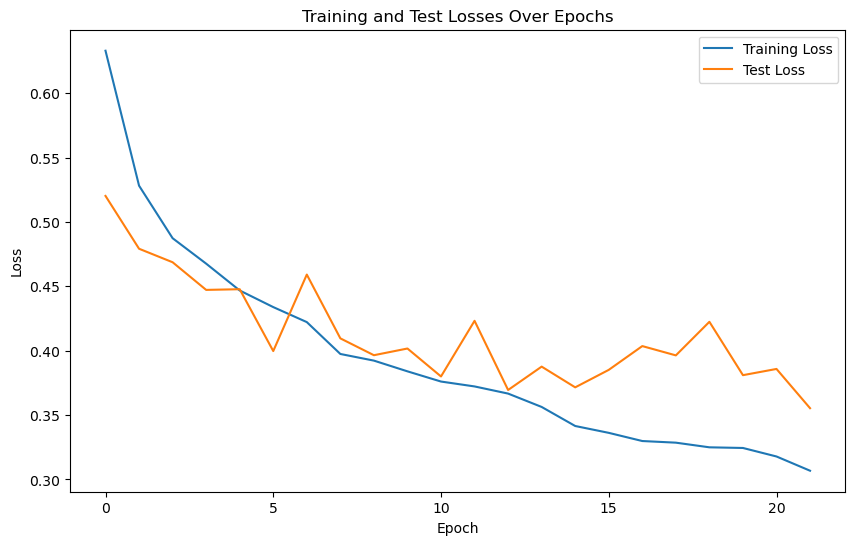

Epoch: 22, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.3023
Tested 110 samples, Loss: 0.4077
Epoch: 23, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2986
Tested 110 samples, Loss: 0.3686
Epoch: 24, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2986
Tested 110 samples, Loss: 0.3900
Epoch: 24, Accuracy[Pixel: 0.9077, IoU: 0.7658, Custom IoU: 0.7700]


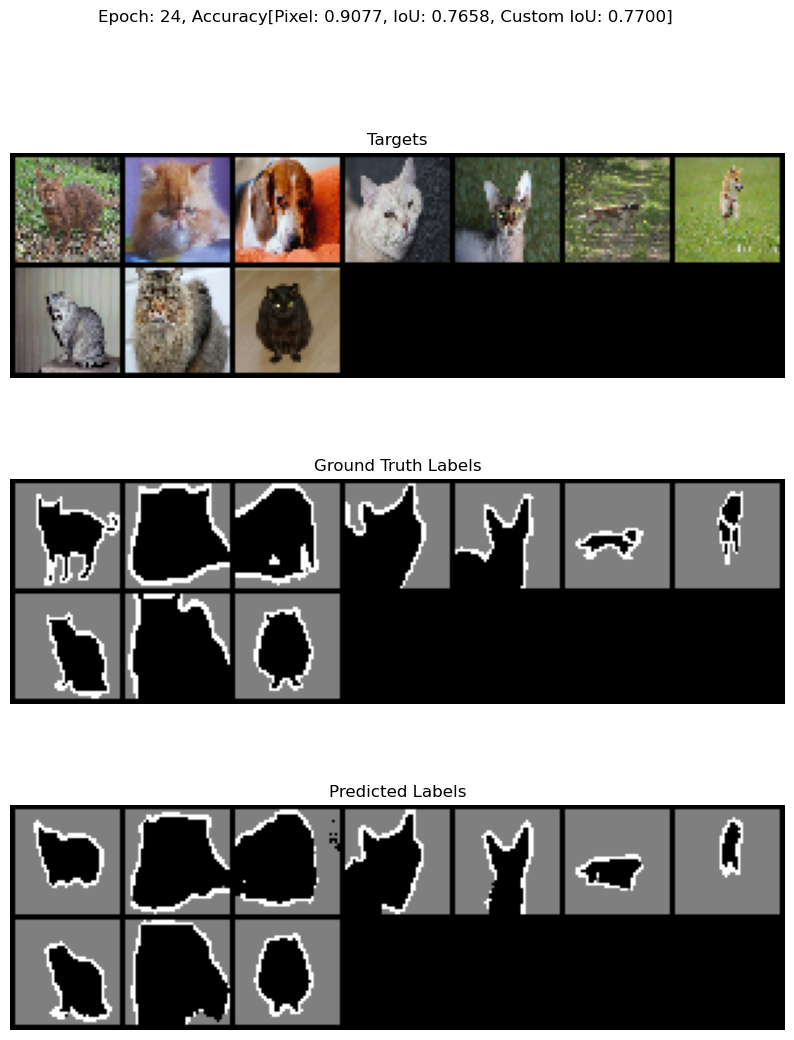

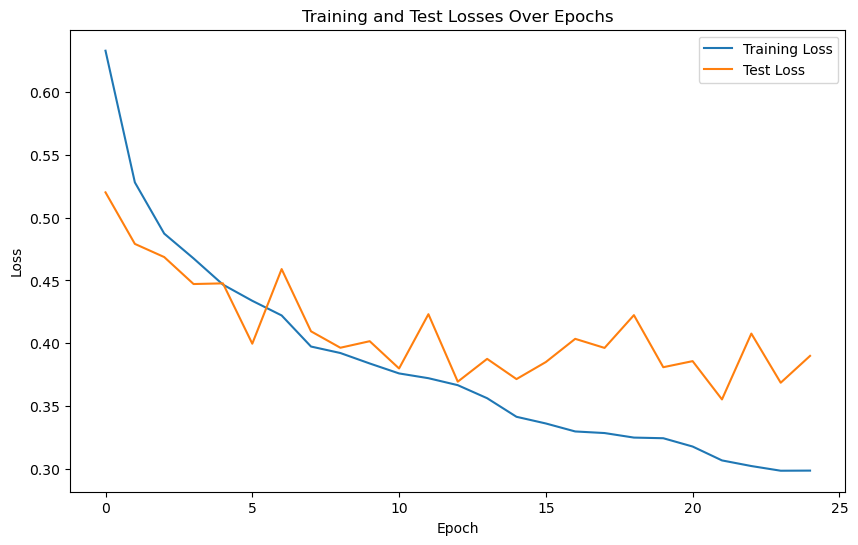

Epoch: 25, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2918
Tested 110 samples, Loss: 0.3614
Epoch: 26, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2920
Tested 110 samples, Loss: 0.3969
Epoch: 27, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2899
Tested 110 samples, Loss: 0.3830
Epoch: 27, Accuracy[Pixel: 0.8994, IoU: 0.7692, Custom IoU: 0.7572]


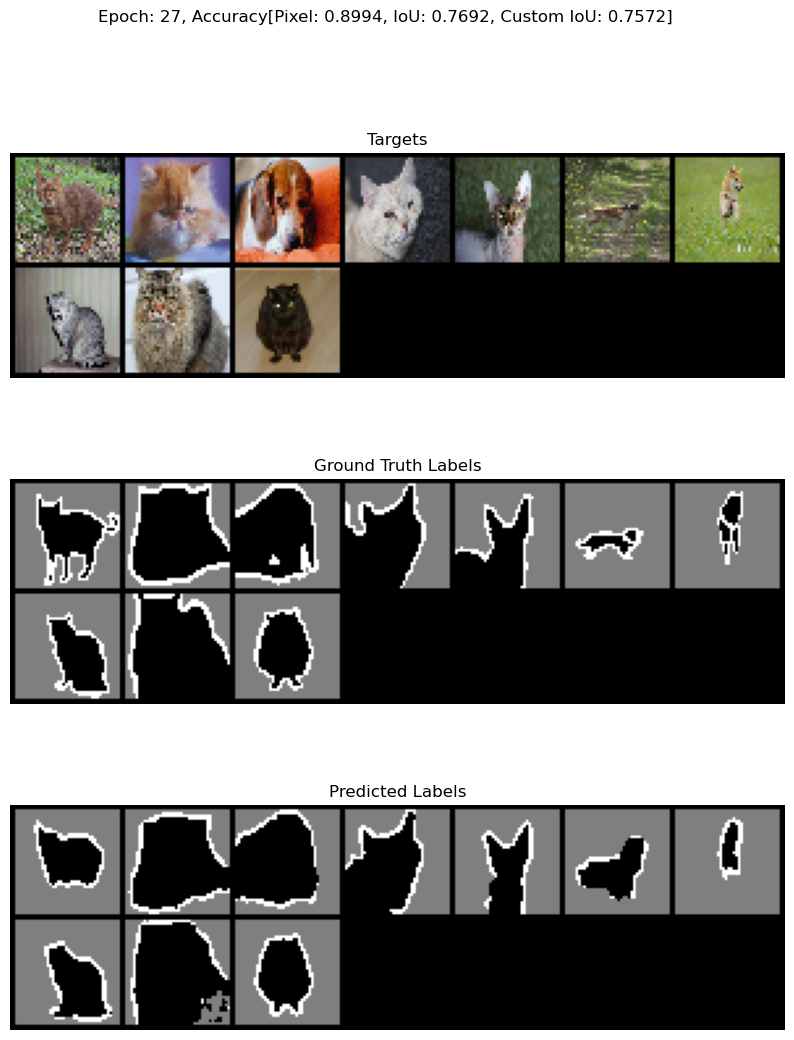

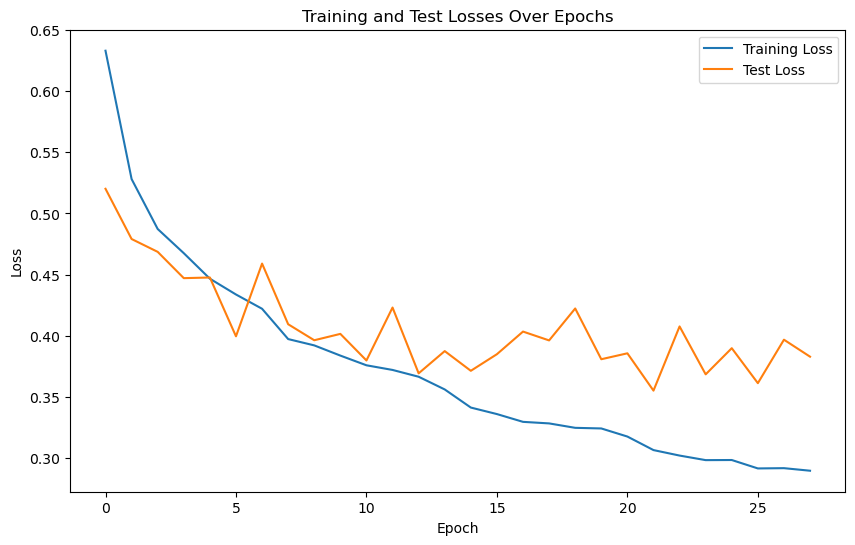

Epoch: 28, Learning Rate: 0.00024009999999999998
Trained 3680 samples, Loss: 0.2806
Tested 110 samples, Loss: 0.4316
Epoch: 29, Learning Rate: 0.00024009999999999998
Trained 3680 samples, Loss: 0.2770
Tested 110 samples, Loss: 0.3944
Epoch: 29, Accuracy[Pixel: 0.9048, IoU: 0.7631, Custom IoU: 0.7623]


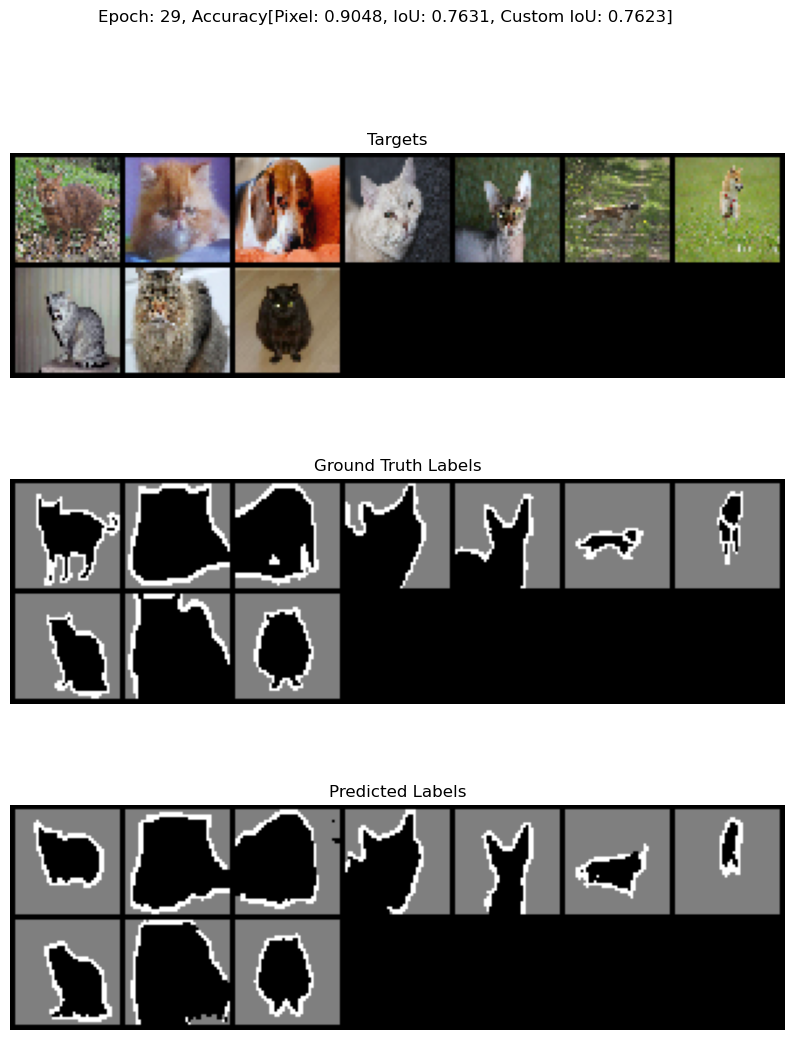

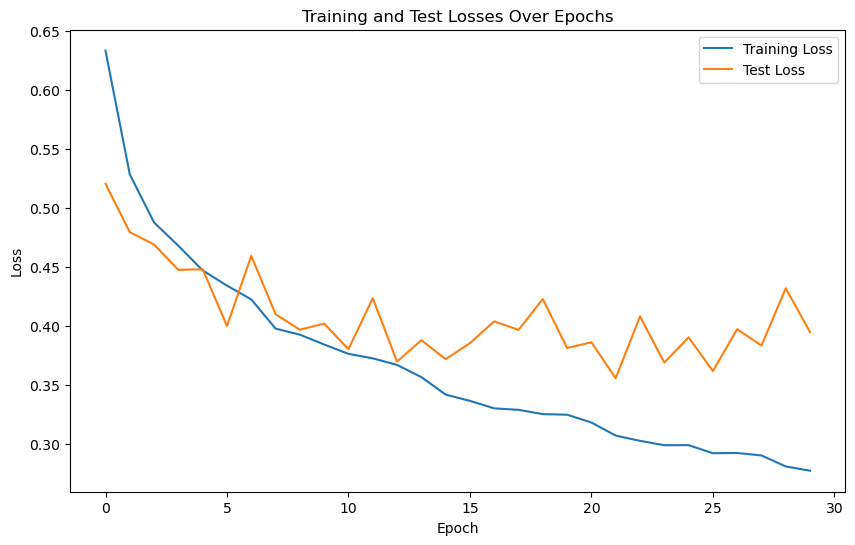

In [18]:
train_loop(unet, pets_train_loader, pets_test_loader, (test_pets_inputs, test_pets_targets), (0, n_epochs), 
                           optimizer, scheduler, save_path=None,print_every=3,show_plots=True)

The Model has 0.14M parameters
Start evaluation ...


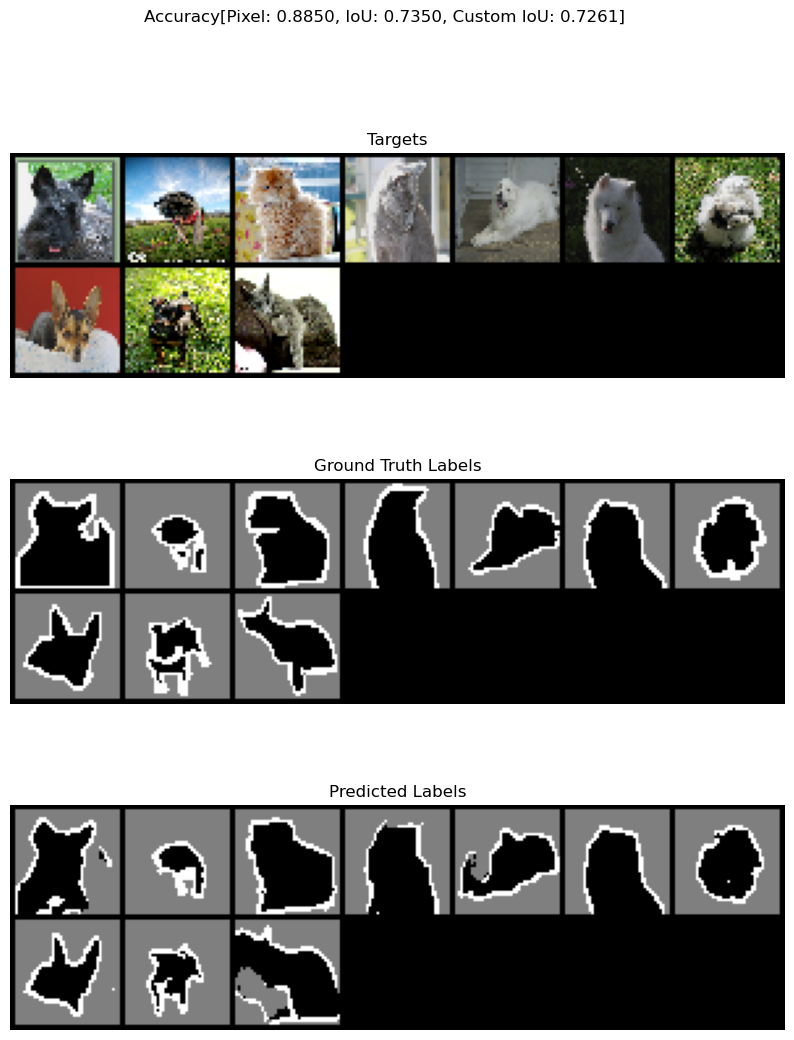

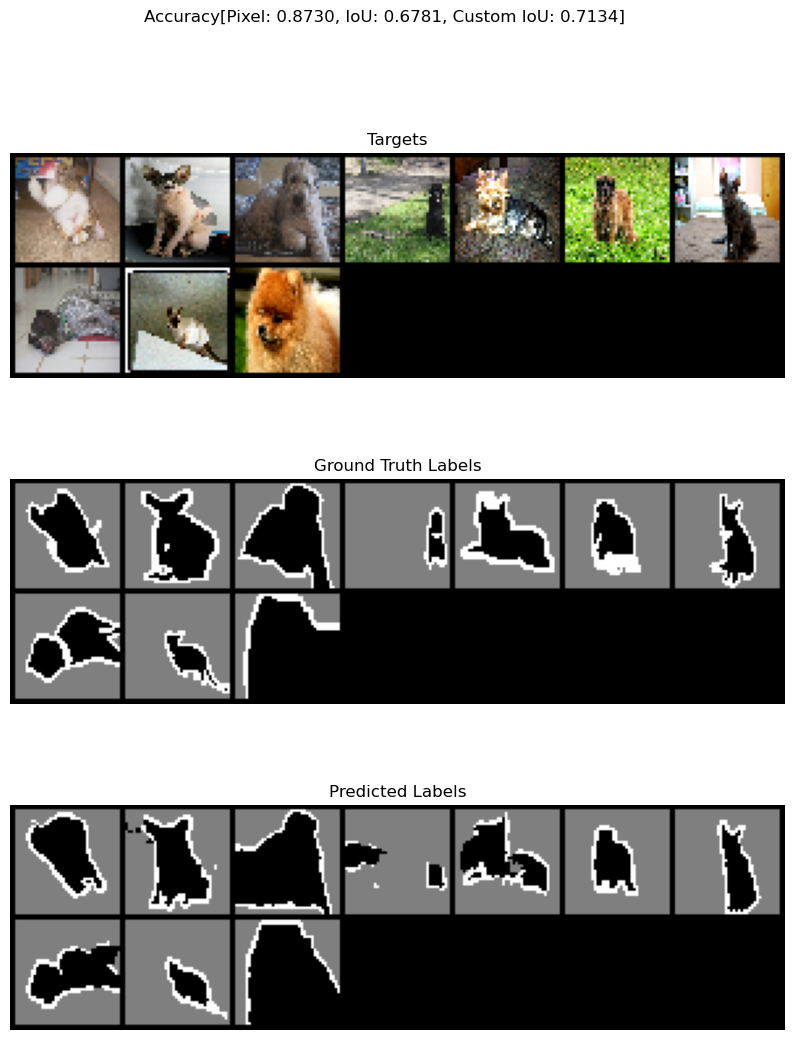

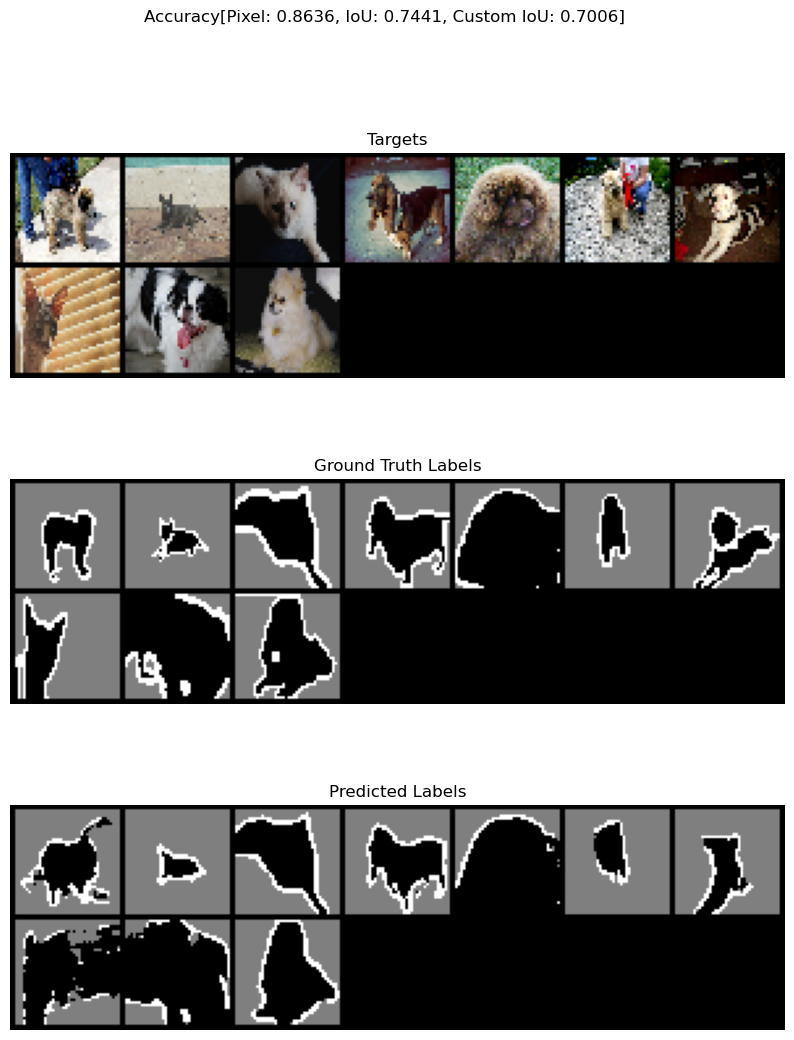

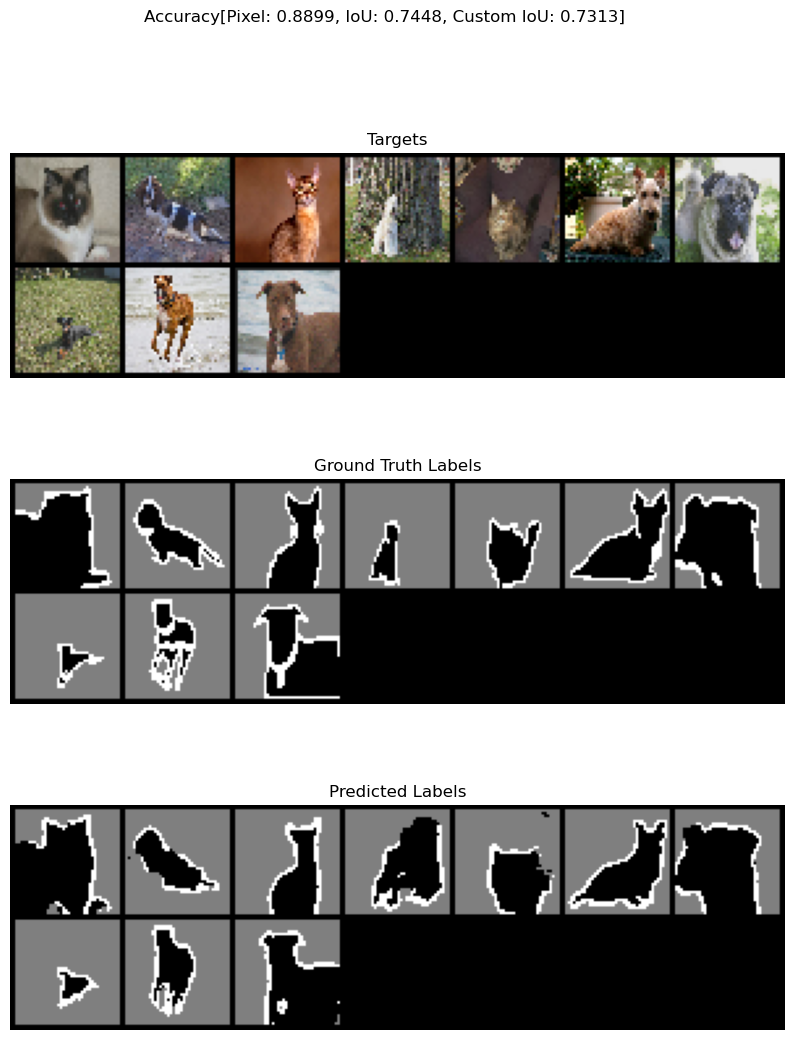

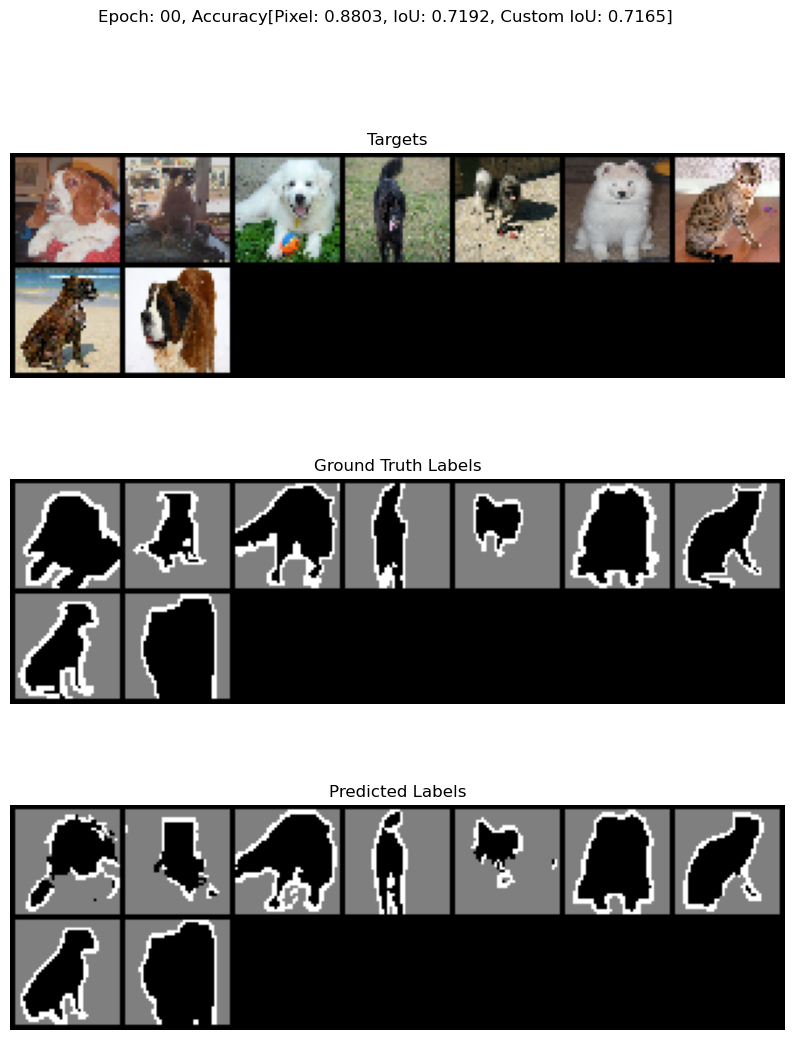

Test Dataset Accuracy
Pixel Accuracy: 0.8549, IoU Accuracy: 0.6878, Custom IoU Accuracy: 0.6857


In [20]:
test_dataset_accuracy(unet, pets_test_loader,show_every_k_batches=100)